해당 파일은 기존 json파일을 filtering해주는 ipynb파일입니다.<br/>
아래와 같은 경우를 filtering하여 제거합니다.<br/>
* points의 개수가 홀수인 경우 <br/>
* points의 개수가 2이하인 경우

새로 만들어진 json은 polygon형태의 box를<br/>여러개의 사각형 형태의 box로 변환해주는데에 쓰입니다.

여기서 사용자가 직접 입력해줘야 하는 부분은<br/>
'**0. 기존 json파일의 위치 정의와 새로 만들어질 json파일 위치 설정**'입니다.

In [1]:
import json

import matplotlib.pyplot as plt
import cv2

import copy
import os

### 0. 기존 json파일의 위치 정의와 새로 만들어질 json파일 위치 설정

In [2]:
# 1. 원본 json파일 경로
json_path = "/opt/ml/input/data/input_revised/annotation.json"
# 2. 이미지가 들어있는 폴더 경로
img_folder_root = "/opt/ml/input/data/input_revised/"
# 3. 새로 만들어질 json파일 경로
new_json_path = "/opt/ml/input/data/input_revised/annotation_filterd.json"

### 1. 원본 json파일 로드

In [3]:
with open(json_path) as f:
    train_json = json.load(f)
    
imgs_name = list(train_json['images'].keys())

In [4]:
print(f'json 파일에 포함된 이미지 개수 : {len(imgs_name)}') # 원본 json에 포함된 이미지 1650개

json 파일에 포함된 이미지 개수 : 1650


### 2. 점의 개수가 2이하 또는 홀수인 경우를 지운 새로운 json파일 생성

In [5]:
train_json_filtered = copy.deepcopy(train_json)
del_list = []
for image_name, image_dict in train_json_filtered['images'].items():
    del_flag = False
    for word in image_dict['words'].values():
        if (len(word['points']) % 2 == 1) or (len(word['points']) <= 2):
            del_flag = True
            break
    if del_flag:
        del_list.append(image_name)

print(f'지울 이미지 개수: {len(del_list)}') # 152개
for file_name in del_list:
    del(train_json_filtered['images'][file_name])

new_imgs_name = list(train_json_filtered['images'].keys())
print(f'새로운 json파일에 포함된 이미지 개수: {len(new_imgs_name)}') # 1498개

지울 이미지 개수: 152
새로운 json파일에 포함된 이미지 개수: 1498


In [6]:
if os.path.isfile(new_json_path):
    raise Exception("이미 해당 파일이 존재합니다.")
else:
    with open(new_json_path, 'w') as f:
        json.dump(train_json_filtered, f, ensure_ascii = False)

### 3. 새로운 json 파일에서 polygon형태 박스 시각화

In [13]:
with open(new_json_path) as f:
    new_train_json = json.load(f)

In [14]:
cnt_polygon = 0
polygons_list = []
for image_name, image_dict in new_train_json['images'].items():
    polygon_flag = False
    for word in image_dict['words'].values():
        if len(word['points']) > 4:
            polygon_flag = True
            break
    if polygon_flag:
        cnt_polygon += 1
        polygons_list.append(image_name)

print(f'polygon이 포함된 이미지 개수: {cnt_polygon}') # 237개

polygon이 포함된 이미지 개수: 237


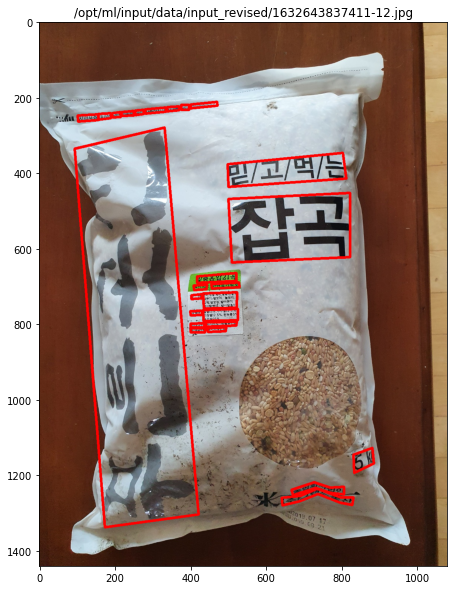

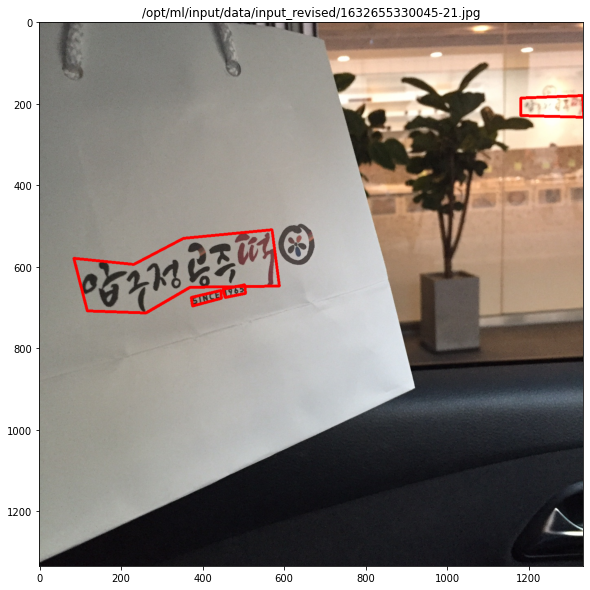

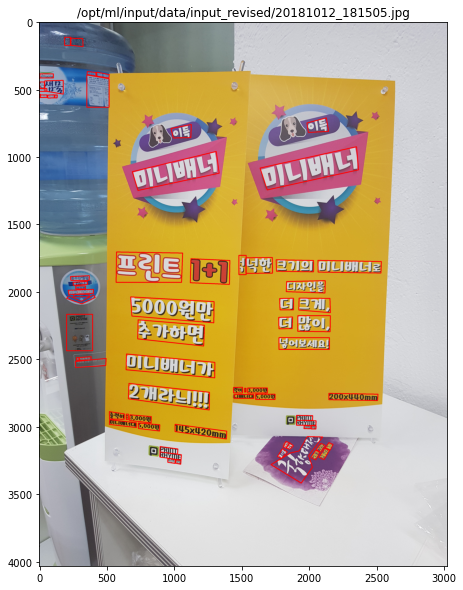

In [15]:
for img_name in polygons_list[:3]:
    img_path = img_folder_root + img_name
    words = new_train_json['images'][img_name]['words']

    plt.figure(figsize=(10,10))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    for key, value in words.items():
        points = value['points']
        for i in range(len(points)-1):
            start_point = points[i]
            end_point = points[i+1]
            cv2.line(img, tuple(map(round, start_point)), tuple(map(round, end_point)), (255,0,0), 5)

        start_point = points[-1]
        end_point = points[0]
        cv2.line(img, tuple(map(round, tuple(start_point))), tuple(map(round, tuple(end_point))), (255,0,0), 5)
    plt.title(img_path)
    plt.imshow(img)

### 4. 새로운 json 파일에서 polygon형태이면서 vertical인 박스 시각화

In [16]:
cnt_polygon_vertical = 0
polygon_vertical_list = []

for image_name, image_dict in new_train_json['images'].items():
    polygon_vertical_flag = False
    for word in image_dict['words'].values():
        if len(word['points']) > 4 and word['orientation'] == 'Vertical':
            polygon_vertical_flag = True
            break
    if polygon_vertical_flag:
        cnt_polygon_vertical += 1
        polygon_vertical_list.append(image_name)

print(f'polygon이면서 vertical인 글자가 들어있는 이미지개수: {cnt_polygon_vertical}') # 5개

polygon이면서 vertical인 글자가 들어있는 이미지개수: 5


In [17]:
print(polygon_vertical_list)

['20210926_110154.jpg', '20180330_103201.jpg', '20210920_112946.jpg', '20210919_151136.jpg', '1632646840914-10.jpg']


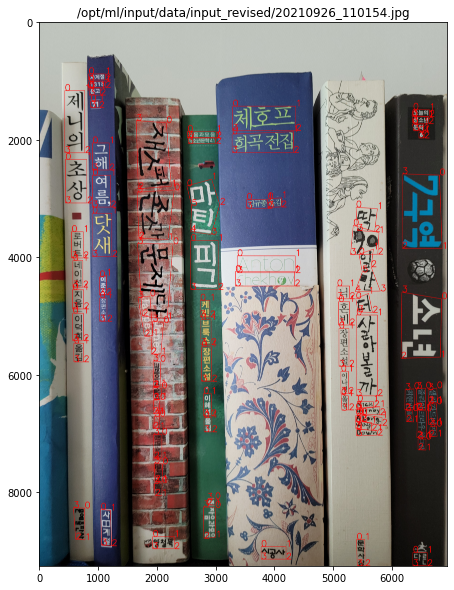

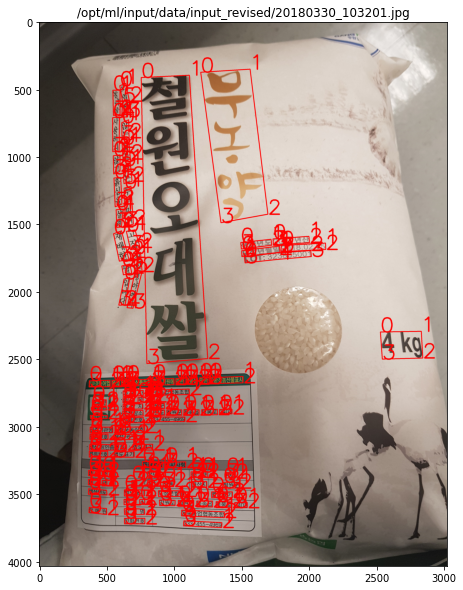

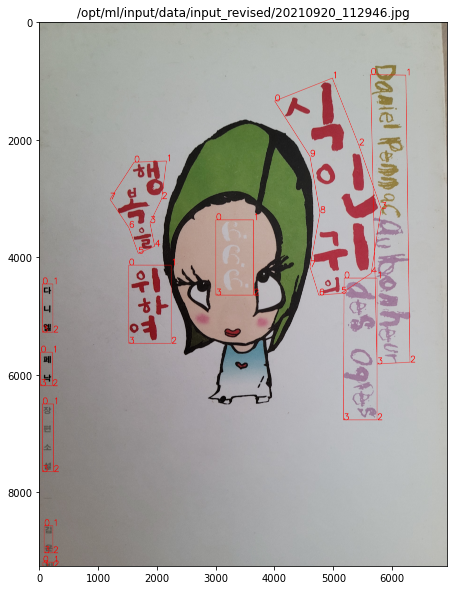

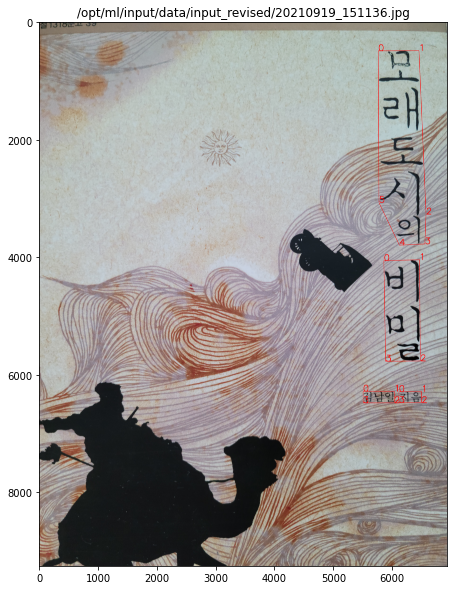

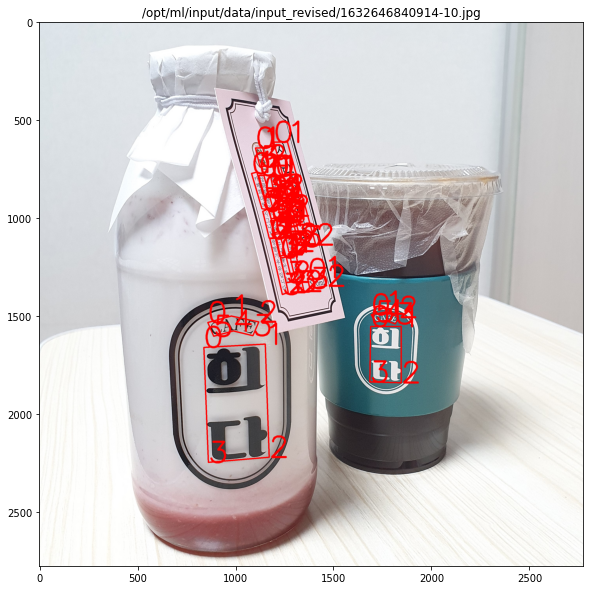

In [18]:
for img_name in polygon_vertical_list:
    img_path = img_folder_root + img_name
    words = new_train_json['images'][img_name]['words']

    plt.figure(figsize=(10,10))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    for key, value in words.items():
        points = value['points']
        for i, point in enumerate(points):
            cv2.putText(img, str(i), org=(int(point[0]), int(point[1])), fontFace=0, fontScale=5, color=(255, 0, 0), thickness=10)

        for i in range(len(points)-1):
            start_point = points[i]
            end_point = points[i+1]
            cv2.line(img, tuple(map(round, start_point)), tuple(map(round, end_point)), (255,0,0), 5)

        start_point = points[-1]
        end_point = points[0]
        cv2.line(img, tuple(map(round, tuple(start_point))), tuple(map(round, tuple(end_point))), (255,0,0), 5)
    plt.title(img_path)
    plt.imshow(img)